# INTRODUCCIÓN

#### En este ejercicio se va a trabajar la analitica exploratoria (EDA) sobre un dataset de variables para la estimacion de fraude en operaciones bancarias.
#### Para ello, vamos a empezar analizando el dataset disponible, el tipo de variables que lo componen y prepararlo para su posterior análisis y modelos de clasificación

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

RANDOM_SEED = 42
n_dim = 64

plt.style.use('bmh')

## 1. Análitica Exploratoria (EDA)

#### Iniciamos el proceso de análisis, estudiando los datos disponibles

In [9]:
df = pd.read_csv('./FraudInputDatav2.csv', encoding = "utf-16") #leemos el fichero de datos, codificado en utf-16
df.head()

,ID,ac,ab,N1,NCE,pm,Value,Credit,Channel,Product,...,N5_Accounts_Card,N5_Devices_Account,N5_Names_Account,N5_CEP_Account,N5_Cards_Account,N5_Cards_Device,Fraud,random,sample,FraudStr
0,1,0.445878,-0.359697,0,0,credit_card,-0.258301,0,CD,F,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.027303,train,Good
1,2,-0.782197,-0.632741,0,0,credit_card,-0.258301,0,CE,F,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.028333,train,Good
2,3,0.298404,0.927510,0,0,credit_card,-0.275540,0,CD,CB,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.008819,check,Good
3,4,-0.664740,2.472159,0,0,credit_card,-0.274538,1,CE,CB,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.038630,train,Good
4,5,-0.223625,-0.617138,0,0,credit_card,-0.218079,0,CD,CA,...,1.0,1.0,1.0,1.0,1.0,1.0,0,0.000657,train,Good


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62763 entries, 0 to 62762
Data columns (total 74 columns):
ID                     62763 non-null int64
ac                     62763 non-null float64
ab                     62763 non-null float64
N1                     62763 non-null int64
NCE                    62763 non-null int64
pm                     62763 non-null object
Value                  62763 non-null float64
Credit                 62763 non-null int64
Channel                62763 non-null object
Product                62763 non-null object
Windows                62763 non-null int64
sl                     62763 non-null object
le                     62763 non-null object
Gift                   62763 non-null int64
Routing                62763 non-null object
QualifiedGood          62763 non-null int64
QualifiedAccount       62763 non-null int64
Risk_Item              62763 non-null float64
Risk_Email             62763 non-null float64
Risk_CEP               62763 non-null f

#### Como podeis ver, se trata de un dataframe compuesto por 3 tipos de columnas, tenemos datos en coma flotante (float64), datos enteros (int64) y los datos tipo object son strings, es decir variables categóricas, las cuales posteriormente tendremos que linearizar

In [11]:
#vamos a linealizar las variables categoricas usando un one-hot-enconding
#para eso el primer paso es encontrar todas las variables categoricas, seran aquellas que tengan el tipo object
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()
#como podeis ver el dataset tiene 8 variables categoricas. No linealizaremos FraudStr y sample ya que serán borradas posteriormente

,pm,Channel,Product,sl,le,Routing,sample,FraudStr
0,credit_card,CD,F,0,YYY,mobile gateway,train,Good
1,credit_card,CE,F,0,YYY,fixed,train,Good
2,credit_card,CD,CB,EU,YYY,fixed,check,Good
3,credit_card,CE,CB,0,YYY,pop,train,Good
4,credit_card,CD,CA,0,YYY,fixed,train,Good


In [12]:
##realizamos la codificación
df_encoding = pd.get_dummies(obj_df, columns=['pm','Channel','Product','sl','le','Routing'])
df_encoding.head()
#como podeis ver se ha creado una columna por cada valor de las variables categoricas.
#Por ejemplo la variable payment ha sido convertida a 4 variables numéricas

,sample,FraudStr,pm_clicknbuy,pm_credit_card,pm_payease,pm_paypal,pm_store_credit,Channel_A,Channel_BA,Channel_BB,...,Routing_aolpop,Routing_aolproxy,Routing_cache proxy,Routing_fixed,Routing_international proxy,Routing_mobile gateway,Routing_none,Routing_pop,Routing_regional proxy,Routing_satellite
0,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,check,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,train,Good,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
#obtenemos el resto de variables para concatenarlo en el df de trabajo
num_df = df.select_dtypes(include=['int64','float64']).copy()
df_num = pd.concat([df_encoding,num_df], axis=1).drop('ID',1).drop('random', 1).drop('sample', 1).drop('FraudStr', 1) #aprovecho para quitar columnas no necesarias


#### Vamos a estudiar la variable Value de forma especial, ya que es una variable que habitualmente puede arrojar mucha informacion respecto al fraude de la operación. Aunque la variable está anonimizada como vereis es una muy buena medida discriminatoria.
#### Podeis realizar estas mismas graficas sobre otros valores que creais de interés

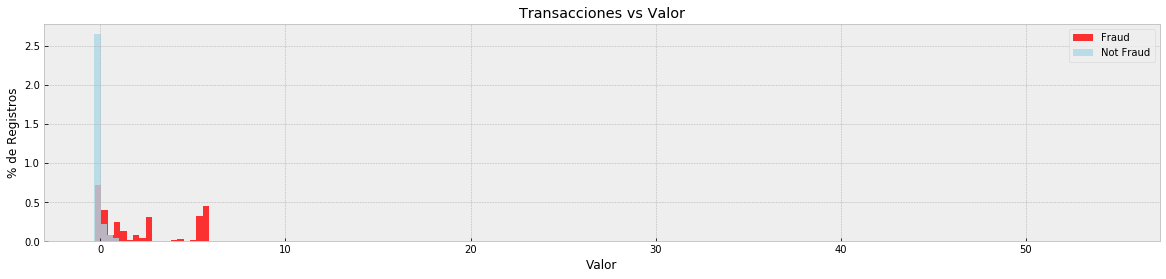

In [14]:
bins=160
plt.figure(figsize=(20,4))
plt.hist(df_num.Value[df_num.Fraud==1],bins=bins,normed=True,alpha=0.8,label='Fraud',color='red')
plt.hist(df_num.Value[df_num.Fraud==0],bins=bins,normed=True,alpha=0.8,label='Not Fraud',color='lightblue')
plt.legend(loc='upper right')
plt.xlabel('Valor')
plt.ylabel('% de Registros')
plt.title('Transacciones vs Valor')
plt.show()

In [15]:
### Como puede verse esta variable puede llegar a ser muy discriminante. Vamos a estudiar el resto de variables

In [16]:
# Estudiamos el resto de variables
y=df_num.Fraud
x=df_num.drop(['Fraud','Value'],axis=1) ## Quitamos la variable Value y la etiqueta Fraud

#### El primer punto es analizar la distribución de variables, tal como hemos visto en el apartado teórico. Lo que estamos buscando son variables cuya distribución difiera entre los casos de Fraude y NoFraude. Es decir, vamos a eliminar del dataset todas las variables cuya distribución sea muy similar entre ambos casos.
#### Para facilitar la visualización de resultados, debido al alto número de variables, crearemos las gráficas en dos grupos

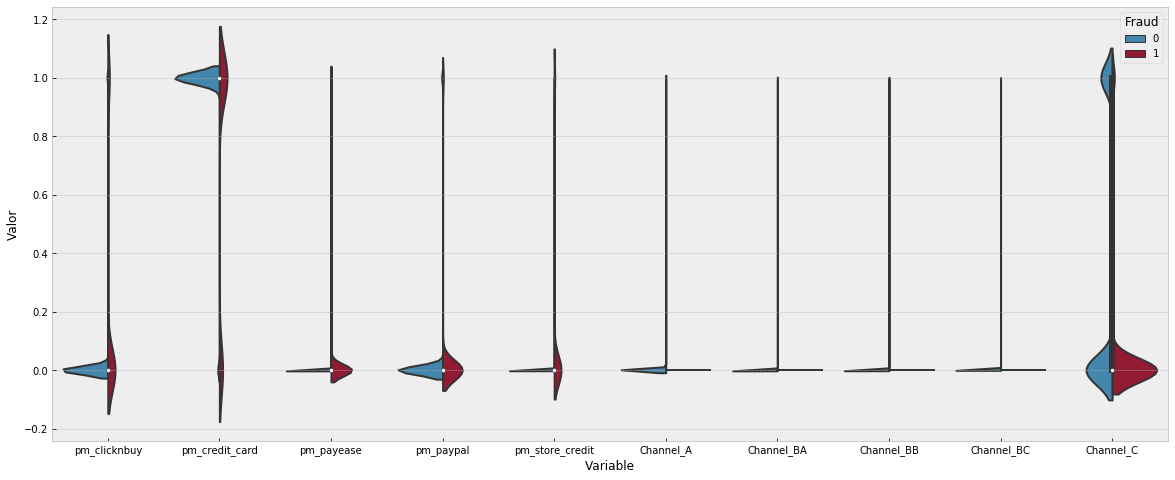

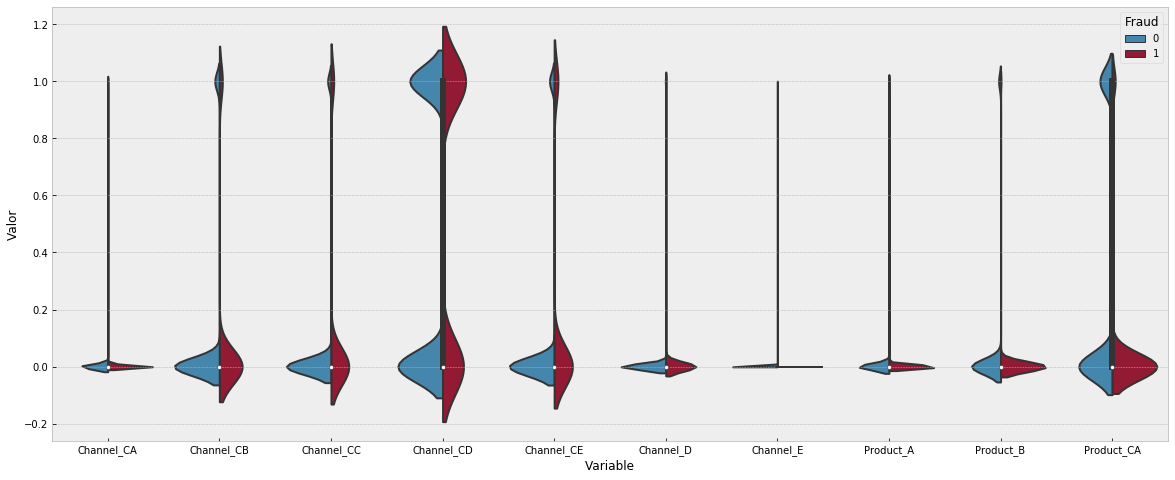

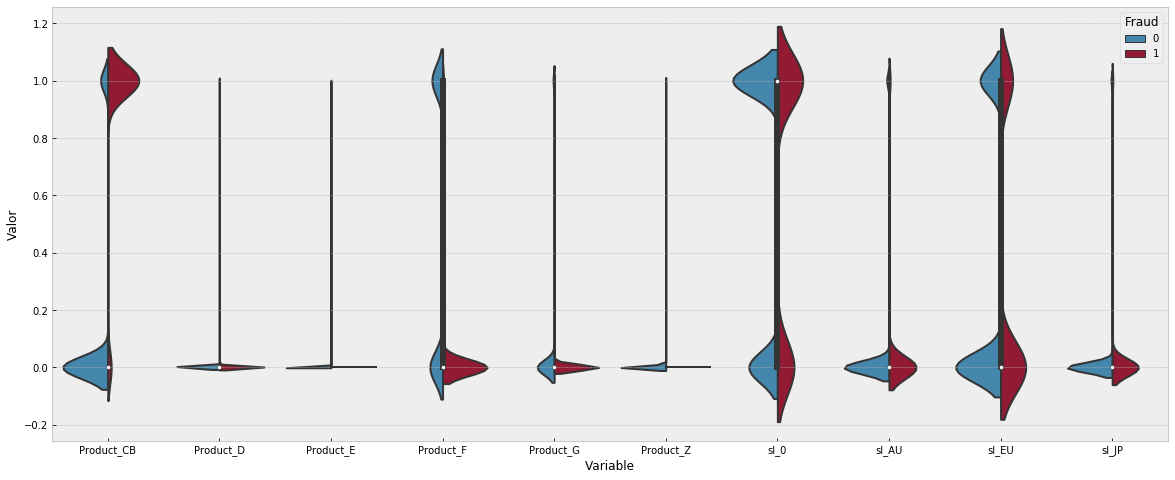

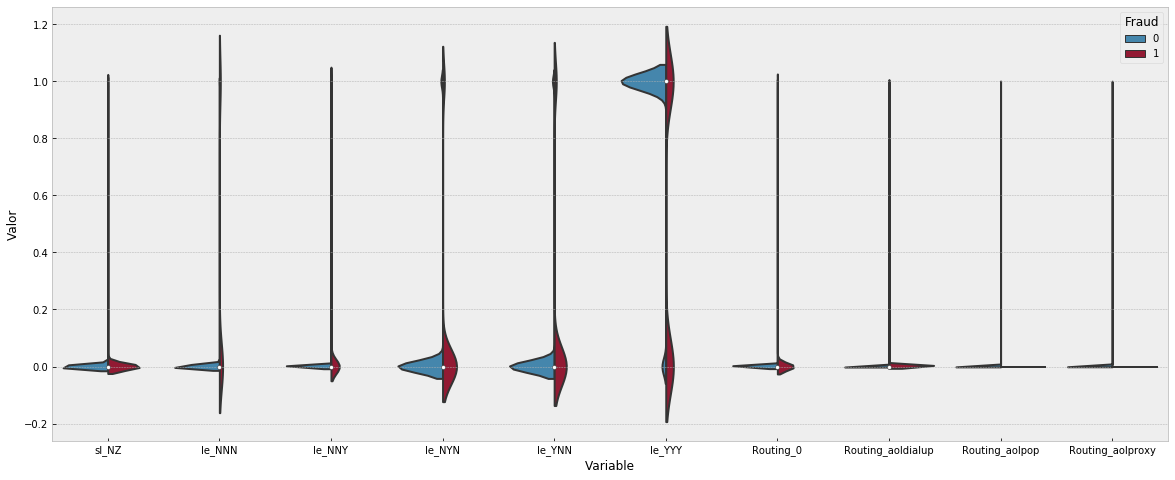

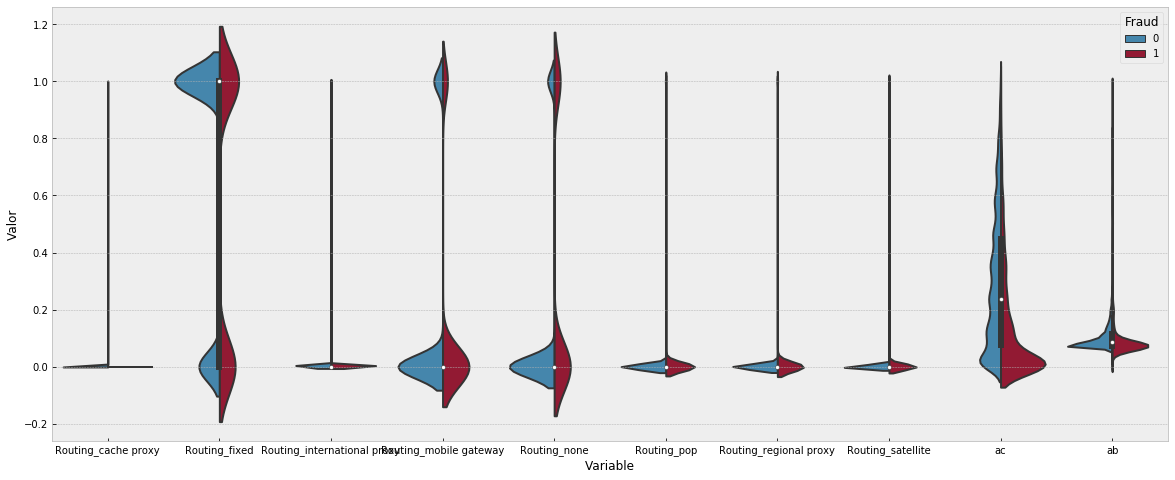

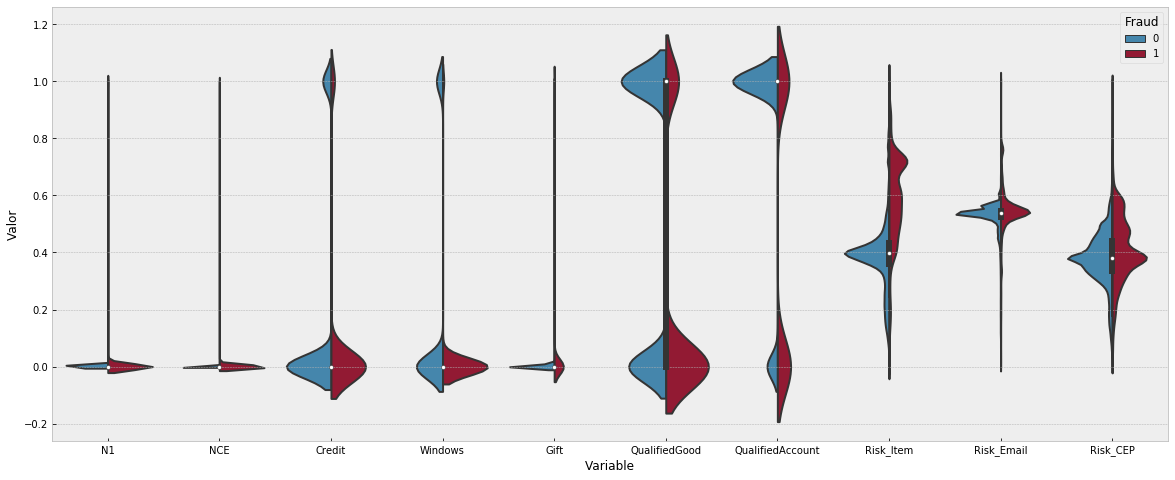

In [17]:
#Primer grupo de variables (0-60) La generación de estas gráficas lleva algo de tiempo de computo
x_scaled=(x-x.min())/(x.max()-x.min()) 
sub_df1=pd.concat([y,x_scaled.iloc[:,0:10]],axis=1)
sub_df2=pd.concat([y,x_scaled.iloc[:,10:20]],axis=1)
sub_df3=pd.concat([y,x_scaled.iloc[:,20:30]],axis=1)
sub_df4=pd.concat([y,x_scaled.iloc[:,30:40]],axis=1)
sub_df5=pd.concat([y,x_scaled.iloc[:,40:50]],axis=1)
sub_df6=pd.concat([y,x_scaled.iloc[:,50:60]],axis=1)
sub_df11=pd.melt(sub_df1,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df22=pd.melt(sub_df2,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df33=pd.melt(sub_df3,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df44=pd.melt(sub_df4,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df55=pd.melt(sub_df5,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df66=pd.melt(sub_df6,id_vars="Fraud",var_name="Variable",value_name='Valor')
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df11, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df22, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df33, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df44, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df55, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df66, split=True)

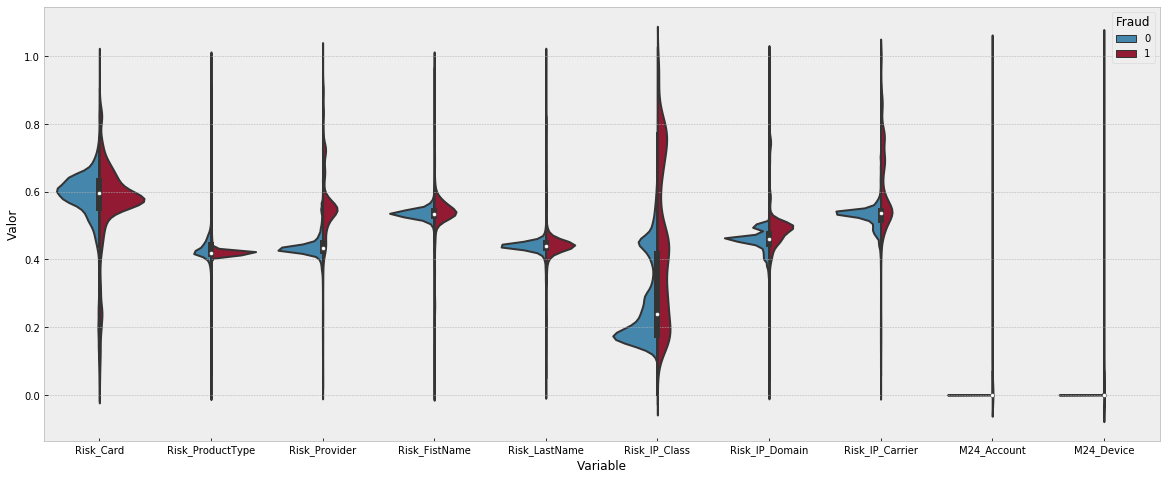

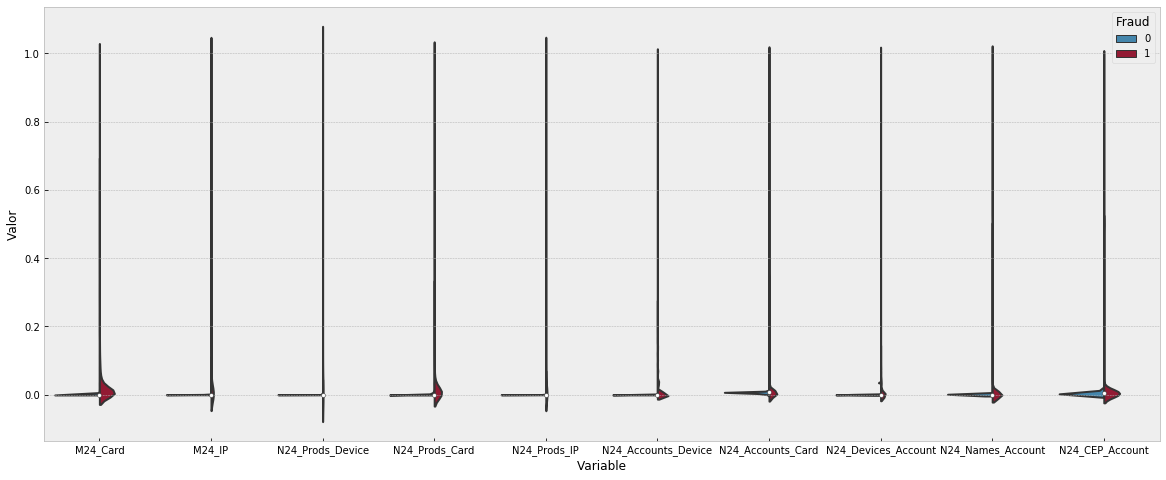

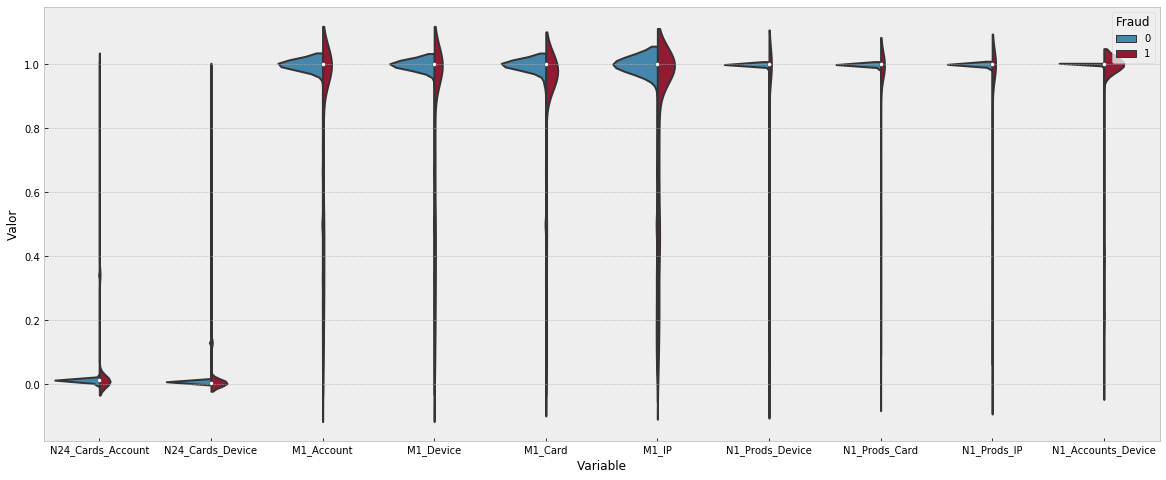

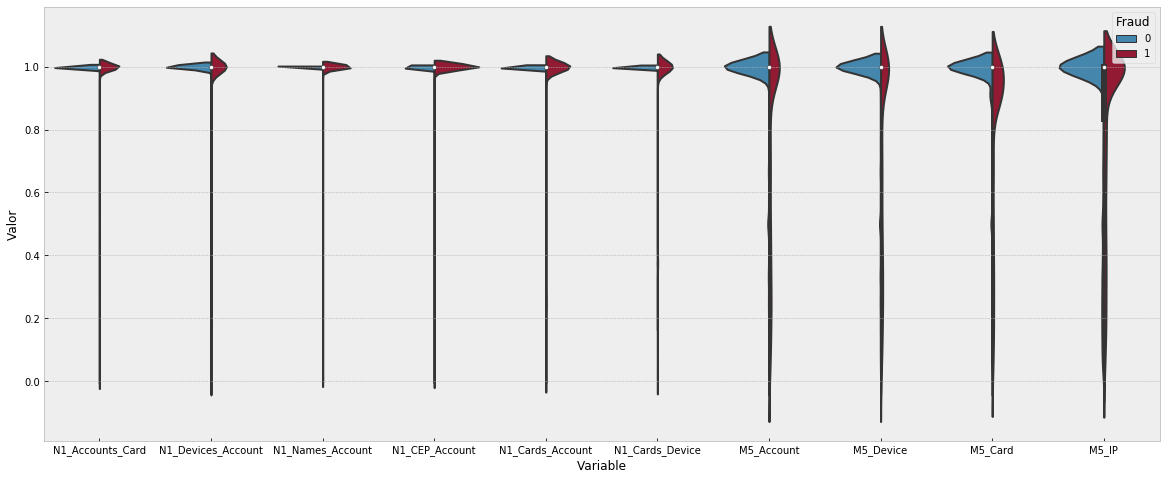

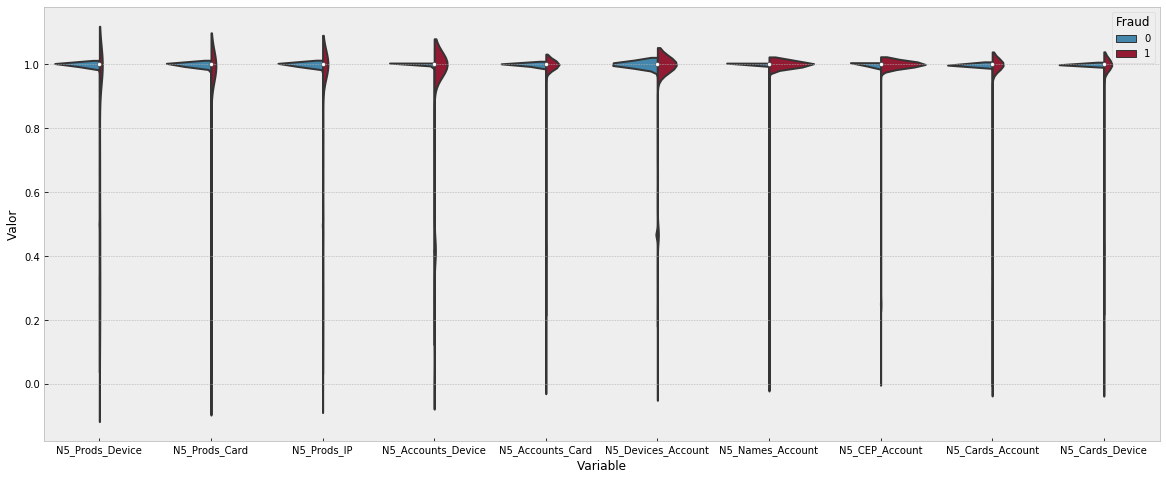

In [18]:
#Segundo grupo de variables (60--) La generación de estas gráficas lleva algo de tiempo de computo
x_scaled=(x-x.min())/(x.max()-x.min()) 
i=60
sub_df1=pd.concat([y,x_scaled.iloc[:,i+0:i+10]],axis=1)
sub_df2=pd.concat([y,x_scaled.iloc[:,i+10:i+20]],axis=1)
sub_df3=pd.concat([y,x_scaled.iloc[:,i+20:i+30]],axis=1)
sub_df4=pd.concat([y,x_scaled.iloc[:,i+30:i+40]],axis=1)
sub_df5=pd.concat([y,x_scaled.iloc[:,i+40:i+50]],axis=1)

sub_df11=pd.melt(sub_df1,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df22=pd.melt(sub_df2,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df33=pd.melt(sub_df3,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df44=pd.melt(sub_df4,id_vars="Fraud",var_name="Variable",value_name='Valor')
sub_df55=pd.melt(sub_df5,id_vars="Fraud",var_name="Variable",value_name='Valor')

plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df11, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df22, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df33, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df44, split=True)
plt.figure(figsize=(20,8))
sns.violinplot(x="Variable",y="Valor",hue="Fraud",data=sub_df55, split=True)


In [19]:
#borramos columnas con una distribución uniforme entre fraude y no fraude
df_features=df_num.drop(['Channel_BA','Channel_BB','Channel_BC','Channel_CA','Channel_D','Channel_E','Product_A','Product_B','Product_CA','Product_D','Product_E','Product_G','Product_Z','sl_JP','sl_NZ','Routing_0','Routing_aoldialup','Routing_aolpop','Routing_aolproxy','Routing_cache proxy','Routing_pop','Routing_regional proxy','Routing_satellite','ac','ab','N1','NCE','QualifiedGood','Risk_Email','Risk_CEP','Risk_Card','Risk_FistName','Risk_LastName','Risk_IP_Class','Risk_IP_Domain','Risk_IP_Carrier'],axis=1)
df_features = pd.concat([df_features,df_num[['Value']]], axis=1) #incluimos el campo Value que fue extraido anteriormente

## 1.1 Balanceo y Normalización de los Datos

#### En este punto hemos dejado el dataset con solamente aquellas variables que a-priori pueden aportar algún tipo de información respecto al fraude. Ahora vamos a analizar el dataset a nivel de tipo de información.
#### Como vereis a continuación, un problema común que nos encontramos en la analítica operacional es que el dataset está desbalanceado, es decir existen muchas más muestras de una clase u etiqueta que de otra.
#### Esto es especialmente importante cuando se detectan anomalías o situaciones como la de este ejercicio de detección de fraude. Existen muchas más transacciones legíticas que fraudulentas

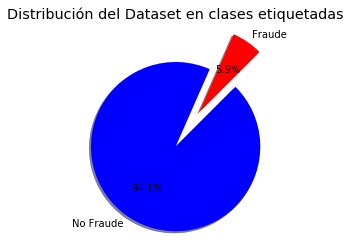

In [20]:
count_classes = pd.value_counts(df_features['Fraud'], sort = True).sort_index()
labels = 'Fraude', 'No Fraude'
sizes = [count_classes[1]/(count_classes[1]+count_classes[0]), count_classes[0]/(count_classes[1]+count_classes[0])]
explode = (0, 0.5,)  
colors = ['red', 'blue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, colors=colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  
plt.title("Distribución del Dataset en clases etiquetadas")
plt.show()

In [21]:
df_features.shape

(62763, 77)

#### Como podeis ver, el dataset está muy desbalanceado. Existen técnicas para mejorar el balanceo del mismo, posteriormente veremos algunas, pero lo más importante es que este tipo de situaciones deben ser tenidas en cuenta a la hora de analizar los resultados de los modelos que apliquemos. Lo veremos cuando analicemos los resultados obtenidos.

#### El siguiente paso va a saer la normalización del dataset

In [22]:
#Vamos a analizar dentro del dataset aquellas columnas cuyo valor minimo sea menor que -1 y valor máximo mayor que 1.
#Para ello vamos a apoyarnos en la funcion describe de un DataFrame que nos proporciona toda esta información y mas
tt = df_features.describe().transpose()
tt[(tt['max']>1) & (tt['min']< -1)]

,count,mean,std,min,25%,50%,75%,max
Risk_Item,62763.0,-1.389215e-14,0.972078,-2.935098,-0.301426,0.000000,0.257719,4.407077
Risk_ProductType,62763.0,3.128379e-15,0.882261,-6.053142,-0.038964,0.000000,0.326596,8.362492
Risk_Provider,62763.0,1.202075e-14,0.998916,-6.767770,-0.310101,-0.187156,0.046344,8.439375


In [23]:
#Como podeis ver existen 3 variables que es necesario normalizar, el resto son correctas
columns_to_norm = ['Risk_Item','Risk_ProductType','Risk_Provider']

In [24]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df_features[columns_to_norm]=min_max_scaler.fit_transform(df_features[columns_to_norm])
# Estudiamos el resto de variables
y=df_features.Fraud
x=df_features.drop('Fraud',axis=1)

In [30]:
tt = df_features.describe().transpose()
tt[(tt['max']>1) & (tt['min']< -1)]
#Ya no quedan variables que normalizar, todas están en los rangos esperados

,count,mean,std,min,25%,50%,75%,max


## 2. Correlación de Variables

#### De forma ideal buscamos incluir en el modelo todas las variables que aporten una componente explicativa alta a la variable objetivo y que tengan una baja correlación entre ellas. Dos variables con una alta correlación significa que, con un grado de error bajo, una puede ser inferida a partir de la otra, y por tanto aportarán información redundante al modelo

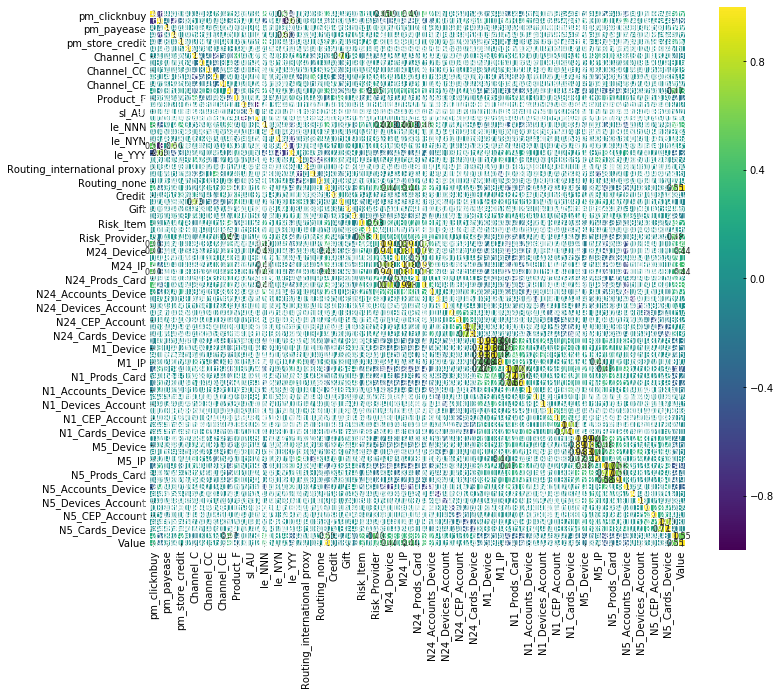

In [31]:
corr_pca = df_features.corr() # We already examined Fraud correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr_pca,
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

## 2.1 Revisión de otras variables

In [ ]:
# Estudiamos el resto de variables
y=df_features.Fraud
x=df_features.drop('Fraud',axis=1)

In [25]:
# PCA
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=n_dim, whiten=True)
sklearn_pca.fit(x)
features_pca = pd.DataFrame(data = sklearn_pca.transform(x))
features_pca= pd.concat([features_pca, y], axis=1)

#### El primer paso es separar los datos en datos de entrenamiento y de test. En este ejercicio se usa una aproximación sencilla, separando los datos en 80% training, 20% test. Se pueden aplicar métodos más avanzados, incluyendo datos de validación posteriores o realizar una randominzación mayor de los datos a obtener, pero para este caso es suficiente esta aproximación.
#### Asi mismo, es necesario separar los datos en variables y etiquetas (X_train, X_test, Y_train, Y_test)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test = train_test_split(features_pca, test_size=0.2, random_state=RANDOM_SEED)
Y_train = X_train['Fraud']
X_train = X_train.drop(['Fraud'], axis=1)
Y_test = X_test['Fraud']
X_test = X_test.drop(['Fraud'], axis=1)

In [27]:
from sklearn.ensemble import RandomForestClassifier

delta = 0.001
n_vars =n_dim
X_train_red = X_train.copy()
X_test_red = X_test.copy()
scores = []
count = 0

In [28]:
from sklearn import metrics
n_estimators = 10
n_dim_init = n_dim
X_train_red = X_train_red[X_train_red.columns[0:n_vars-1]]
X_test_red = X_test_red[X_test_red.columns[0:n_vars-1]]
    
rf =RandomForestClassifier(n_estimators, max_depth=None,  random_state=0, n_jobs=-1)
rf.fit(X_train_red, Y_train)
Y_pred = rf.predict(X_test_red)
pscore = metrics.recall_score(Y_test, Y_pred, average ='binary')
n_vars = n_vars-1
thresold = 0.01

scores.append(pscore)
count = count+1

importances = list(rf.feature_importances_)
imp_index = importances.index(min(importances))

while((delta > thresold) | ( n_vars >1)):
    
    X_train_red= X_train_red.drop(X_train_red.columns[[imp_index]],axis=1)
    X_test_red =X_test_red.drop(X_test_red.columns[[imp_index]],axis=1)
    
    rf =RandomForestClassifier(n_estimators, max_depth=None,  random_state=0, n_jobs=-1)
    rf.fit(X_train_red, Y_train)
    Y_pred = rf.predict(X_test_red)
    pscore_new = metrics.recall_score(Y_test, Y_pred, pos_label = 1, average ='binary')
    delta = pscore_new-pscore
    pscore = pscore_new
    n_vars =n_vars-1
    scores.append(pscore)
    count= count+1
    importances = list(rf.feature_importances_)
    imp_index = importances.index(min(importances))

n_dim=n_dim_init

#### Visualizamos el error a medida que quitamos variables del sistema. Como veis, existe un conjunto de variables que no aportan casi información al resultado, y otro conjunto que supone una caida drástica de los resultados del modelo.

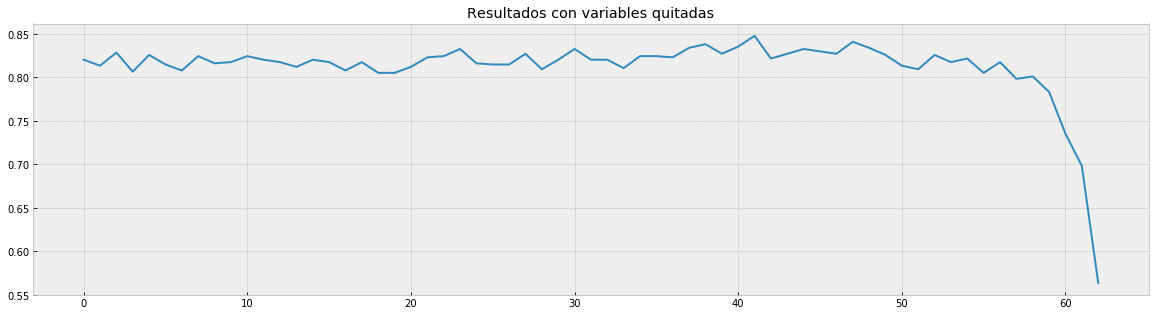

In [29]:
plt.figure(figsize=(20, 5))
plt.title('Resultados con variables quitadas')
plt.plot(np.arange(0,n_dim-1, 1),scores)

[  5.18768230e+00   1.75019211e+00   1.33320128e+00   1.07084941e+00
   9.56817446e-01   8.54333958e-01   5.52016326e-01   5.26936797e-01
   4.71577009e-01   4.36438655e-01   4.18490880e-01   3.22598154e-01
   2.50812585e-01   2.32857746e-01   2.19505264e-01   1.61044200e-01
   1.54618789e-01   1.47940431e-01   1.47351871e-01   1.24689935e-01
   1.19482285e-01   1.02246316e-01   9.45175825e-02   9.05514815e-02
   7.58849260e-02   7.54351733e-02   7.02340147e-02   5.82904149e-02
   5.50346070e-02   4.63886408e-02   4.37529499e-02   2.05134814e-02
   2.01403611e-02   1.69534236e-02   1.40745923e-02   1.32705999e-02
   9.41898507e-03   9.13221742e-03   8.15269655e-03   7.14087185e-03
   5.54588380e-03   5.01048226e-03   4.28071894e-03   3.68278491e-03
   3.57412206e-03   3.41877964e-03   3.09918088e-03   3.02259040e-03
   2.91298413e-03   2.31731870e-03   2.02122225e-03   1.87456218e-03
   1.46680862e-03   1.36559302e-03   1.35627950e-03   1.27223364e-03
   1.04993481e-03   9.19656996e-04

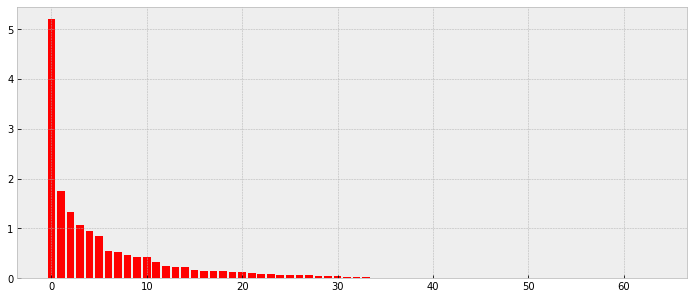

In [32]:
plt.figure(figsize=(12, 5))
rects1 = plt.bar(np.arange(n_dim),sklearn_pca.explained_variance_, color='r')
print(sklearn_pca.explained_variance_)  

In [33]:
# nos quedaremos con las primeras 32 variables
features_pca = features_pca.iloc[:,0:32]
features_pca.shape

(62763, 32)

## ..........DE ACA EN ADELANTE ES IGUAL PARA TODOS.................

## 3 Preparación de Datos para aprendizaje y lanzamiento del modelo

In [43]:
#Generamos una función de ayuda para el resto de módulos de cara a visualizar las matrices de confusión
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, roc_curve
def plot_confusion_matrix(y_test, pred):
    
    y_test_legit = y_test.value_counts()[0]
    y_test_fraud = y_test.value_counts()[1]
    
    cfn_matrix = confusion_matrix(y_test, pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Matriz de Confusión')
    plt.ylabel('Categorias reales')
    plt.xlabel('Categorias estimadas')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Matriz de Confusión normalizada')
    plt.ylabel('Categorias reales')
    plt.xlabel('Categorias estimadas')
    plt.show()
    
    print('---Report de clasificación---')
    print(classification_report(y_test,pred))

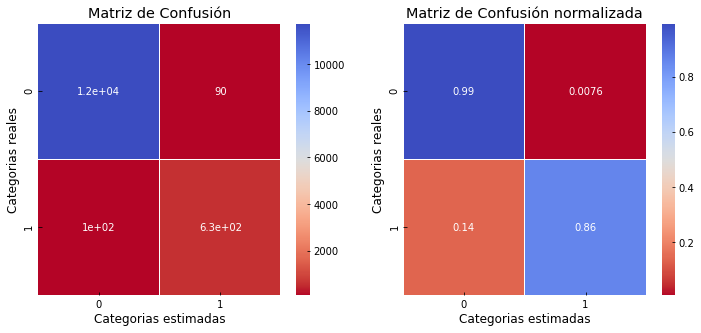

---Report de clasificación---
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     11824
          1       0.87      0.86      0.87       729

avg / total       0.98      0.98      0.98     12553



In [38]:
from sklearn.ensemble import RandomForestClassifier
rf =RandomForestClassifier(n_estimators=100, max_depth=None,  random_state=0)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
plot_confusion_matrix(Y_test, Y_pred)

##### A simple vista los resultados del modelo son bastante buenos. En el resultado medio vemos una precisión del 98% y un recall del 98% también. Recordemos que el término precisión nos indica la capacidad del clasificador para no etiquetar como positivo una muestra negativa. Es decir, la capacidad del modelo para no dar registros correctos como fraudulentos. El término recall nos indica la capacidad del clasificador para encontrar todas las muestra positivas.
##### Pero si vemos en más detalle los resultados, vemos cómo en el caso de la clase 1, es decir Fraude, los resultados no son tan buenos. Si combinamos estos datos con la matriz de confusión (no normalizada) vemos cómo el modelo estima correctamente 630 registros sobre un total de aproximadamente 720, pero que etiqueta como fraudulentas 150 operaciones que en realidad son correctas.

#### Dependiendo de cómo se operativice el modelo, esto puede ser un buen o mal resultado. Como pregunta abierta, ¿es mejor reducir el rendimiento en los registros correctos a  cambio de mejorar el rendimiento del modelo en operaciones fraudulentas? Veamos algunos ejemplos

### 3.1 Desbalancear el DataSet

#### Una estrategia a seguir es reducir el número de muestras correctas, para intentar balancear el dataset. Al no ser un dataset especialmente grande es necesario tener cuidado con esta operación, ya que reducir drasticamente el número de muestras penalizará el modelo al no tener suficientes datos para su aprendizaje.

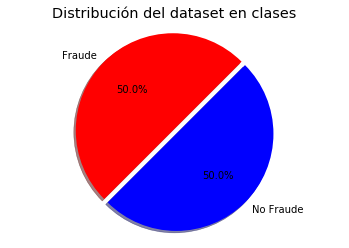

In [39]:
from sklearn.utils import shuffle

Train_Data= pd.concat([X_train, Y_train], axis=1)
X_1 =Train_Data[ Train_Data["Fraud"]==1 ]
X_0=Train_Data[Train_Data["Fraud"]==0]

X_0=shuffle(X_0,random_state=42).reset_index(drop=True)
X_1=shuffle(X_1,random_state=42).reset_index(drop=True)

ALPHA=1 #sobre esta variable podeis jugar para cambiar la distribución del dataset

X_0=X_0.iloc[:round(len(X_1)*ALPHA),:]
data_d=pd.concat([X_1, X_0])

count_classes = pd.value_counts(data_d['Fraud'], sort = True).sort_index()
labels = 'Fraude', 'No Fraude'
sizes = [count_classes[1]/(count_classes[1]+count_classes[0]), count_classes[0]/(count_classes[1]+count_classes[0])]
explode = (0, 0.05,)
colors = ['red', 'blue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, colors=colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribución del dataset en clases")
plt.show()

In [40]:
data_d.shape

(5950, 65)

In [41]:
Y_d=data_d['Fraud']
X_d=data_d.drop(['Fraud'],axis=1)

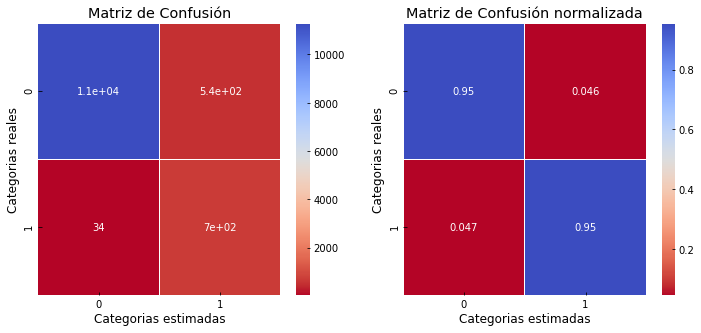

---Report de clasificación---
             precision    recall  f1-score   support

          0       1.00      0.95      0.98     11824
          1       0.56      0.95      0.71       729

avg / total       0.97      0.95      0.96     12553



In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
rf =RandomForestClassifier(n_estimators=100, max_depth=None, random_state=0, n_jobs=-1)
rf.fit(X_d, Y_d) 
Y_test_predicted=rf.predict(X_test)

plot_confusion_matrix(Y_test, Y_test_predicted)

#### En términos generales se trata de un modelo que arroja mejores resultados, aunque si miramos la matriz de confusión ha aumentado de 20 a 38 los falsos negativos, y ha disminuido de 950 a 350 aproximadamente en los falsos positivos

10
50
100
250
500
1000


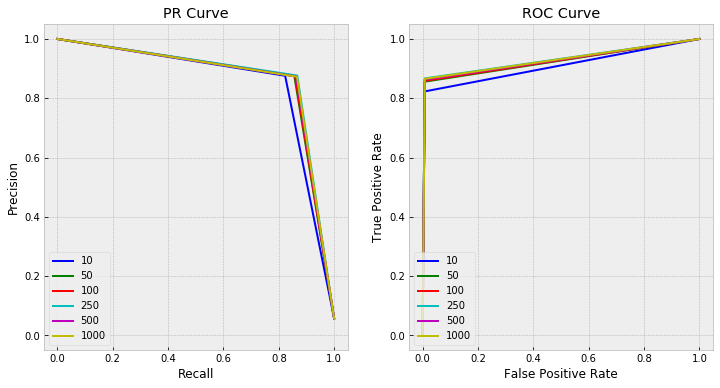

In [47]:
# Unsampled training data # rf_prec_recall_n_est_unsampled_unweighted
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_est,k in zip([10, 50, 100, 250, 500,1000],'bgrcmy'):
    print(n_est)
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=None, random_state=0, n_jobs=-1)
    rf.fit(X_train,Y_train)
    y_pred = rf.predict(X_test)

    p,r,_ = precision_recall_curve(Y_test, y_pred)
    tpr,fpr,_ = roc_curve(Y_test, y_pred)
    
    ax1.plot(r,p,c=k,label=n_est)
    ax2.plot(tpr,fpr,c=k,label=n_est)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()


#### Vamos a visualizar los resultados del algoritmo RandomForest, enfocado en analizar la importancia que el sistema ha dado a cada una de las variables. Esto será el punto de entrada para trabajar una selección de variables iterativa en la siguiente práctica

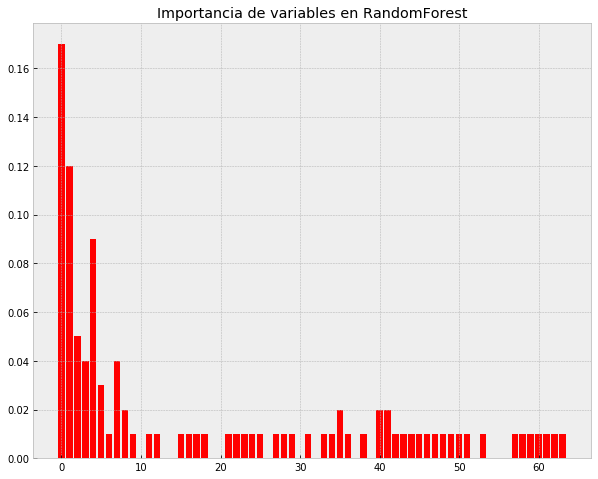

In [48]:

importances = list(rf.feature_importances_)
feature_list = list(pd.DataFrame(data =X_train).columns)
feature_importances = [(X_train, round(importance, 2)) for X_train, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

plt.figure(figsize=(10, 8))
plt.title('Importancia de variables en RandomForest')

feature_importances_ix = [pair[0] for pair in feature_importances]
feature_importances_val = [pair[1] for pair in feature_importances]
rects1 = plt.bar(feature_importances_ix,feature_importances_val, color='r')

## 4 Selección de variables y reducción dimensional

#### En este ejemplo para visualizarlo mejor vamos a trabajar con un PCA de 2 dimensiones. Aviso! en el ejercicio que hagais vosotros usar más dimensiones!

In [49]:
#PCA
n_dim = 12
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=n_dim, whiten=True)
sklearn_pca.fit(x)
features_pca = pd.DataFrame(data = sklearn_pca.transform(x))

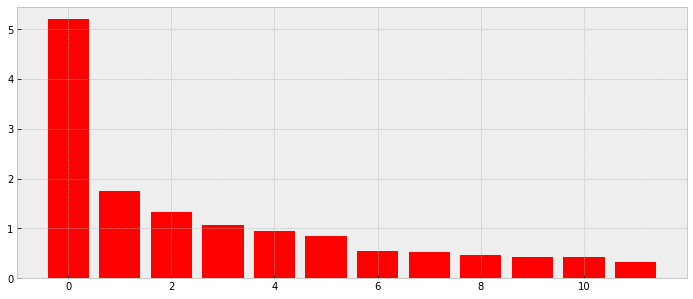

In [50]:
plt.figure(figsize=(12, 5))
rects1 = plt.bar(np.arange(n_dim),sklearn_pca.explained_variance_, color='r')

In [51]:
# nos quedaremos con las primeras 32 variables
features_pca2 = features_pca.values
features_pca2.shape

(62763, 12)

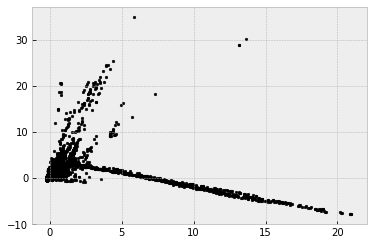

In [52]:
plt.scatter(features_pca2[:,0], features_pca2[:,1], c='black', s=7)

#### Vamos a aplicar un algoritmo sencillo de clustering. Si queréis podeis probar con otros algoritmos más potentes que este.
#### Lo primero, voy a buscar el número de clusters óptimos. Para ello, preparo un bucle para probar de 1 a 20 clusters, y observo la distancia de los puntos a su centro de cluster, como medida de rendimiento

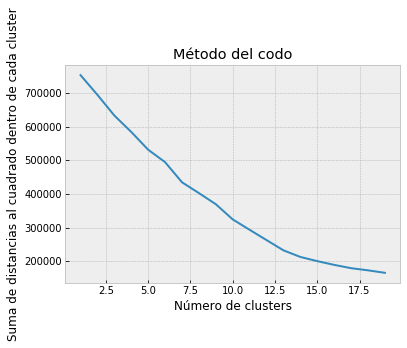

In [53]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

res = []
N_max=20
N_min=1
for i in range(N_min, N_max):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(features_pca2)
    # Obtenemos la suma de las distancias al cuadrado dentro de cada cluster
    res.append(kmeans.inertia_)

plt.plot(range(N_min, N_max), res)
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Suma de distancias al cuadrado dentro de cada cluster')
plt.show()

In [54]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(features_pca2)
#consigo los clusters que genera el algoritmo como un vector y lo uno todo en un mismo dataframe
Z = kmeans.predict(features_pca2)
x = np.transpose(features_pca2)
y = (df_features['Fraud'].values)
z= np.array([Z]).T
xx =np.hstack((x.T,np.array([y]).T))
all = np.hstack((xx,z))
alldf = pd.DataFrame(all)

In [55]:
alldf.head()
#columna 0: pca dim 1, columna 1: pca dim2, columna2: fraude/buena columna 3: cluster

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.147641,-0.188523,-0.167498,0.000458,-0.135526,-0.002737,-1.429649,0.017085,0.009888,-0.317678,-0.840936,1.883275,0.0,1.0
1,-0.152217,-0.236080,-0.140475,-0.002006,-0.134369,0.031371,0.445517,-0.030966,0.113981,0.194359,-0.743693,-0.498533,0.0,1.0
2,-0.129085,-0.151247,-0.072026,-0.046360,-0.150856,-0.003924,-0.701292,0.008630,0.053466,-0.181758,1.430936,-1.184150,0.0,3.0
3,-0.142323,-0.131591,-0.074885,-0.049229,-0.122994,0.027034,-0.396305,0.022206,0.196060,0.208077,-0.749441,-0.963904,0.0,1.0
4,-0.132598,-0.181247,-0.052449,-0.050451,-0.157329,-0.010563,-0.492016,0.021772,0.112131,-0.045207,-0.750340,-0.821497,0.0,1.0


#### Vamos a realizar una visualización sencilla, donde separamos los datos en buenos y fraudulentos para cada cluster (TODO: esto que yo hago a mano puede automatizarse para cualquier número de clusters)

In [60]:
n_fraude = 5
n_cluster = 3
alldfgood0 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 0]
alldffraud0 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 0]
alldfgood1 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 1]
alldffraud1 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 1]
alldfgood2 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 2]
alldffraud2 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 2]
alldfgood3 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 3]
alldffraud3 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 3]
alldfgood4 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 4]
alldffraud4 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 4]
alldfgood5 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 5]
alldffraud5 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 5]

#### Si observais los datos, su estructura, vereis que hay clusters con solo fraude, solo buenos, y mezclados

In [61]:
alldffraud1.shape

(0, 14)

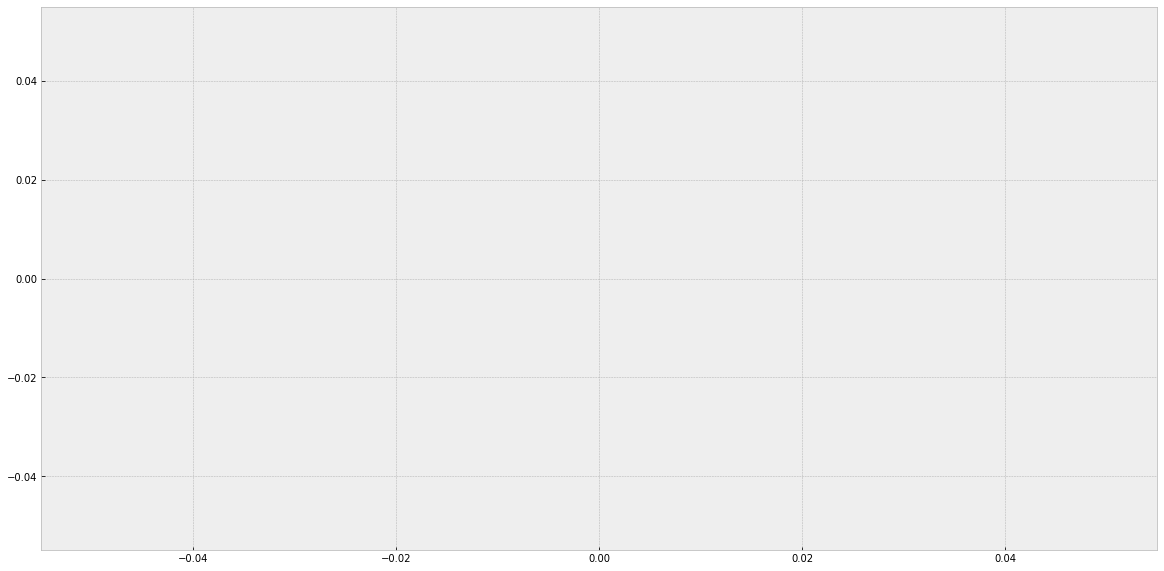

In [58]:
alldfgood = alldf.loc[alldf[2] == 0].values
alldffraud = alldf.loc[alldf[2] == 1].values
plt.figure(figsize=(20, 10))
plt.scatter(alldffraud[:,0], alldffraud[:,1],alpha = 0.5, c='red', s=1)
plt.scatter(alldfgood[:,0], alldfgood[:,1], alpha=0.5, c='black', s=1)

ZeroDivisionError: integer division or modulo by zero

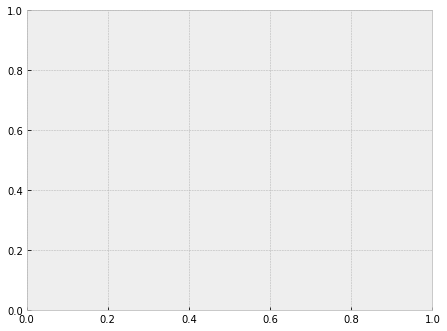

In [59]:
#tarda un poco en pintar toda la información. 
#Conviene que useis alpha, aunque tarde un poco más, marca la transparencia de los puntos. Si son opacos no lo vereis bien
plt.figure(figsize=(16, 32))
plt.subplot(5, 2, 1)
plt.plot(np.transpose(alldffraud0.values[:,0:n_fraude]), alpha=0.8,color='red')
plt.plot(np.transpose(alldfgood0.values[:,0:n_fraude]),alpha=0.8, color='grey')

plt.title("Valores para cluster 0")
plt.subplot(5, 2, 2)
#plt.plot(np.transpose(alldfgood1.values[:,0:n_fraude]),alpha=0.8, color='grey',linewidth=0.1)
plt.plot(np.transpose(alldffraud1.values[:,0:n_fraude]),alpha=0.8, color='red')
plt.title("Valores para cluster 1")
plt.subplot(5, 2, 3)
plt.plot(np.transpose(alldffraud2.values[:,0:n_fraude]),alpha=0.8, color='red')
plt.plot(np.transpose(alldfgood2.values[:,0:n_fraude]),alpha=0.8, color='grey')

plt.title("Valores para cluster 2")
plt.subplot(5, 2, 4)
plt.plot(np.transpose(alldffraud3.values[:,0:n_fraude]),alpha=0.8, color='red')
#plt.plot(np.transpose(alldfgood3.values[:,0:n_fraude]), alpha=0.8,color='grey')
plt.title("Valores para cluster 3")
plt.subplot(5, 2, 5)
plt.plot(np.transpose(alldffraud4.values[:,0:n_fraude]), alpha=0.8,color='red')
plt.plot(np.transpose(alldfgood4.values[:,0:n_fraude]), alpha=0.8,color='grey')

plt.title("Valores para cluster 4")
plt.subplot(5, 2, 6)
#plt.plot(np.transpose(alldfgood5.values[:,0:n_fraude]),alpha=0.8, color='grey')
plt.plot(np.transpose(alldffraud5.values[:,0:n_fraude]),alpha=0.8, color='red')
plt.title("Valores para cluster 5")

#### Ahora vamos a calcular la distancia de cada punto al centro de su cluster

In [ ]:
kmeans.cluster_centers_

In [ ]:
alldf['centers']=alldf[n_cluster]

In [ ]:
cluster_number = alldf['centers'].values.astype('int64')

In [ ]:
centers = kmeans.cluster_centers_

In [ ]:
positions = alldf.iloc[:,0:n_fraude].values
positions

In [ ]:
d=np.sqrt(((positions-centers[cluster_number])**2).sum(axis=1)) #calculamos la distancia

In [ ]:
alldf = pd.DataFrame(np.hstack((alldf.values,np.array([d]).T))) #añadimos la columna al dataset

In [ ]:
alldf.head()

In [ ]:
#volvemos a generar la separación en clusters y buenos/fraudulentos

alldfgood0 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 0][n_cluster+2]
alldffraud0 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 0][n_cluster+2]
alldfgood1 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 1][n_cluster+2]
alldffraud1 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 1][n_cluster+2]
alldfgood2 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 2][n_cluster+2]
alldffraud2 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 2][n_cluster+2]
alldfgood3 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 3][n_cluster+2]
alldffraud3 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 3][n_cluster+2]
alldfgood4 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 4][n_cluster+2]
alldffraud4 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 4][n_cluster+2]
alldfgood5 = alldf.loc[alldf[n_fraude] == 0].loc[alldf[n_cluster] == 5][n_cluster+2]
alldffraud5 = alldf.loc[alldf[n_fraude] == 1].loc[alldf[n_cluster] == 5][n_cluster+2]

In [ ]:
plt.figure(figsize=(16, 32))
plt.subplot(5, 2, 1)
plt.scatter( range(0,alldfgood0.size),alldfgood0, c='black', s=7)
plt.scatter( range(0,alldffraud0.size),alldffraud0, c='red', s=7)
plt.subplot(5, 2, 2)
plt.scatter( range(0,alldfgood1.size),alldfgood1, c='black', s=7)
plt.scatter( range(0,alldffraud1.size),alldffraud1, c='red', s=7)
plt.subplot(5, 2, 3)
plt.scatter( range(0,alldfgood2.size),alldfgood2, c='black', s=7)
plt.scatter( range(0,alldffraud2.size),alldffraud2, c='red', s=7)
plt.subplot(5, 2, 4)
plt.scatter( range(0,alldfgood3.size),alldfgood3, c='black', s=7)
plt.scatter( range(0,alldffraud3.size),alldffraud3, c='red', s=7)
plt.subplot(5, 2, 5)
plt.scatter( range(0,alldfgood4.size),alldfgood4, c='black', s=7)
plt.scatter( range(0,alldffraud4.size),alldffraud4, c='red', s=7)
plt.subplot(5, 2, 6)
plt.scatter( range(0,alldfgood5.size),alldfgood5, c='black', s=7)
plt.scatter( range(0,alldffraud5.size),alldffraud5, c='red', s=7)